In [236]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta
import ta







In [237]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [238]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [239]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [240]:



df = getQuotes(frameM30)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1577817000,1.12215,1.12308,1.12215,1.12260,1972,7,0
1,1577818800,1.12261,1.12270,1.12224,1.12255,1278,7,0
2,1577820600,1.12255,1.12290,1.12230,1.12285,925,8,0
3,1577822400,1.12287,1.12287,1.12234,1.12241,631,7,0
4,1577824200,1.12242,1.12250,1.12222,1.12229,342,8,0
...,...,...,...,...,...,...,...,...
45269,1692201600,1.09020,1.09102,1.08958,1.09080,4807,8,0
45270,1692203400,1.09080,1.09228,1.09072,1.09084,6411,8,0
45271,1692205200,1.09085,1.09230,1.09063,1.09151,5543,8,0
45272,1692207000,1.09151,1.09158,1.08959,1.09062,4983,8,0


In [241]:





def ichimoku(df, kijunSenLookUp = 26, tenkanSenLookup = 9, chikouSpanShift = 26):
    ichimoku = ta.trend.IchimokuIndicator(high=df['high'],low=df['low'],window1=tenkanSenLookup,window2=kijunSenLookup,window3=kijunSenLookup)
    df['kijun_sen'] = ichimoku.ichimoku_base_line()
    df['chikou_span'] = df['close'].shift(-chikouSpanShift)
    df['tenkan_sen'] = ichimoku.ichimoku_conversion_line()
    return df







In [242]:








kijunSenLookup = 26
tenkanSenLookup = 9
chikouSpanShift = 26


df = ichimoku(df, kijunSenLookup, tenkanSenLookup, chikouSpanShift)

df









,time,open,high,low,close,tick_volume,spread,real_volume,kijun_sen,chikou_span,tenkan_sen
0,1577817000,1.12215,1.12308,1.12215,1.12260,1972,7,0,NaN,1.12040,NaN
1,1577818800,1.12261,1.12270,1.12224,1.12255,1278,7,0,NaN,1.12050,NaN
2,1577820600,1.12255,1.12290,1.12230,1.12285,925,8,0,NaN,1.12070,NaN
3,1577822400,1.12287,1.12287,1.12234,1.12241,631,7,0,NaN,1.12061,NaN
4,1577824200,1.12242,1.12250,1.12222,1.12229,342,8,0,NaN,1.12095,NaN
...,...,...,...,...,...,...,...,...,...,...,...
45269,1692201600,1.09020,1.09102,1.08958,1.09080,4807,8,0,1.091495,NaN,1.091395
45270,1692203400,1.09080,1.09228,1.09072,1.09084,6411,8,0,1.091495,NaN,1.091310
45271,1692205200,1.09085,1.09230,1.09063,1.09151,5543,8,0,1.091495,NaN,1.091115
45272,1692207000,1.09151,1.09158,1.08959,1.09062,4983,8,0,1.091495,NaN,1.090940


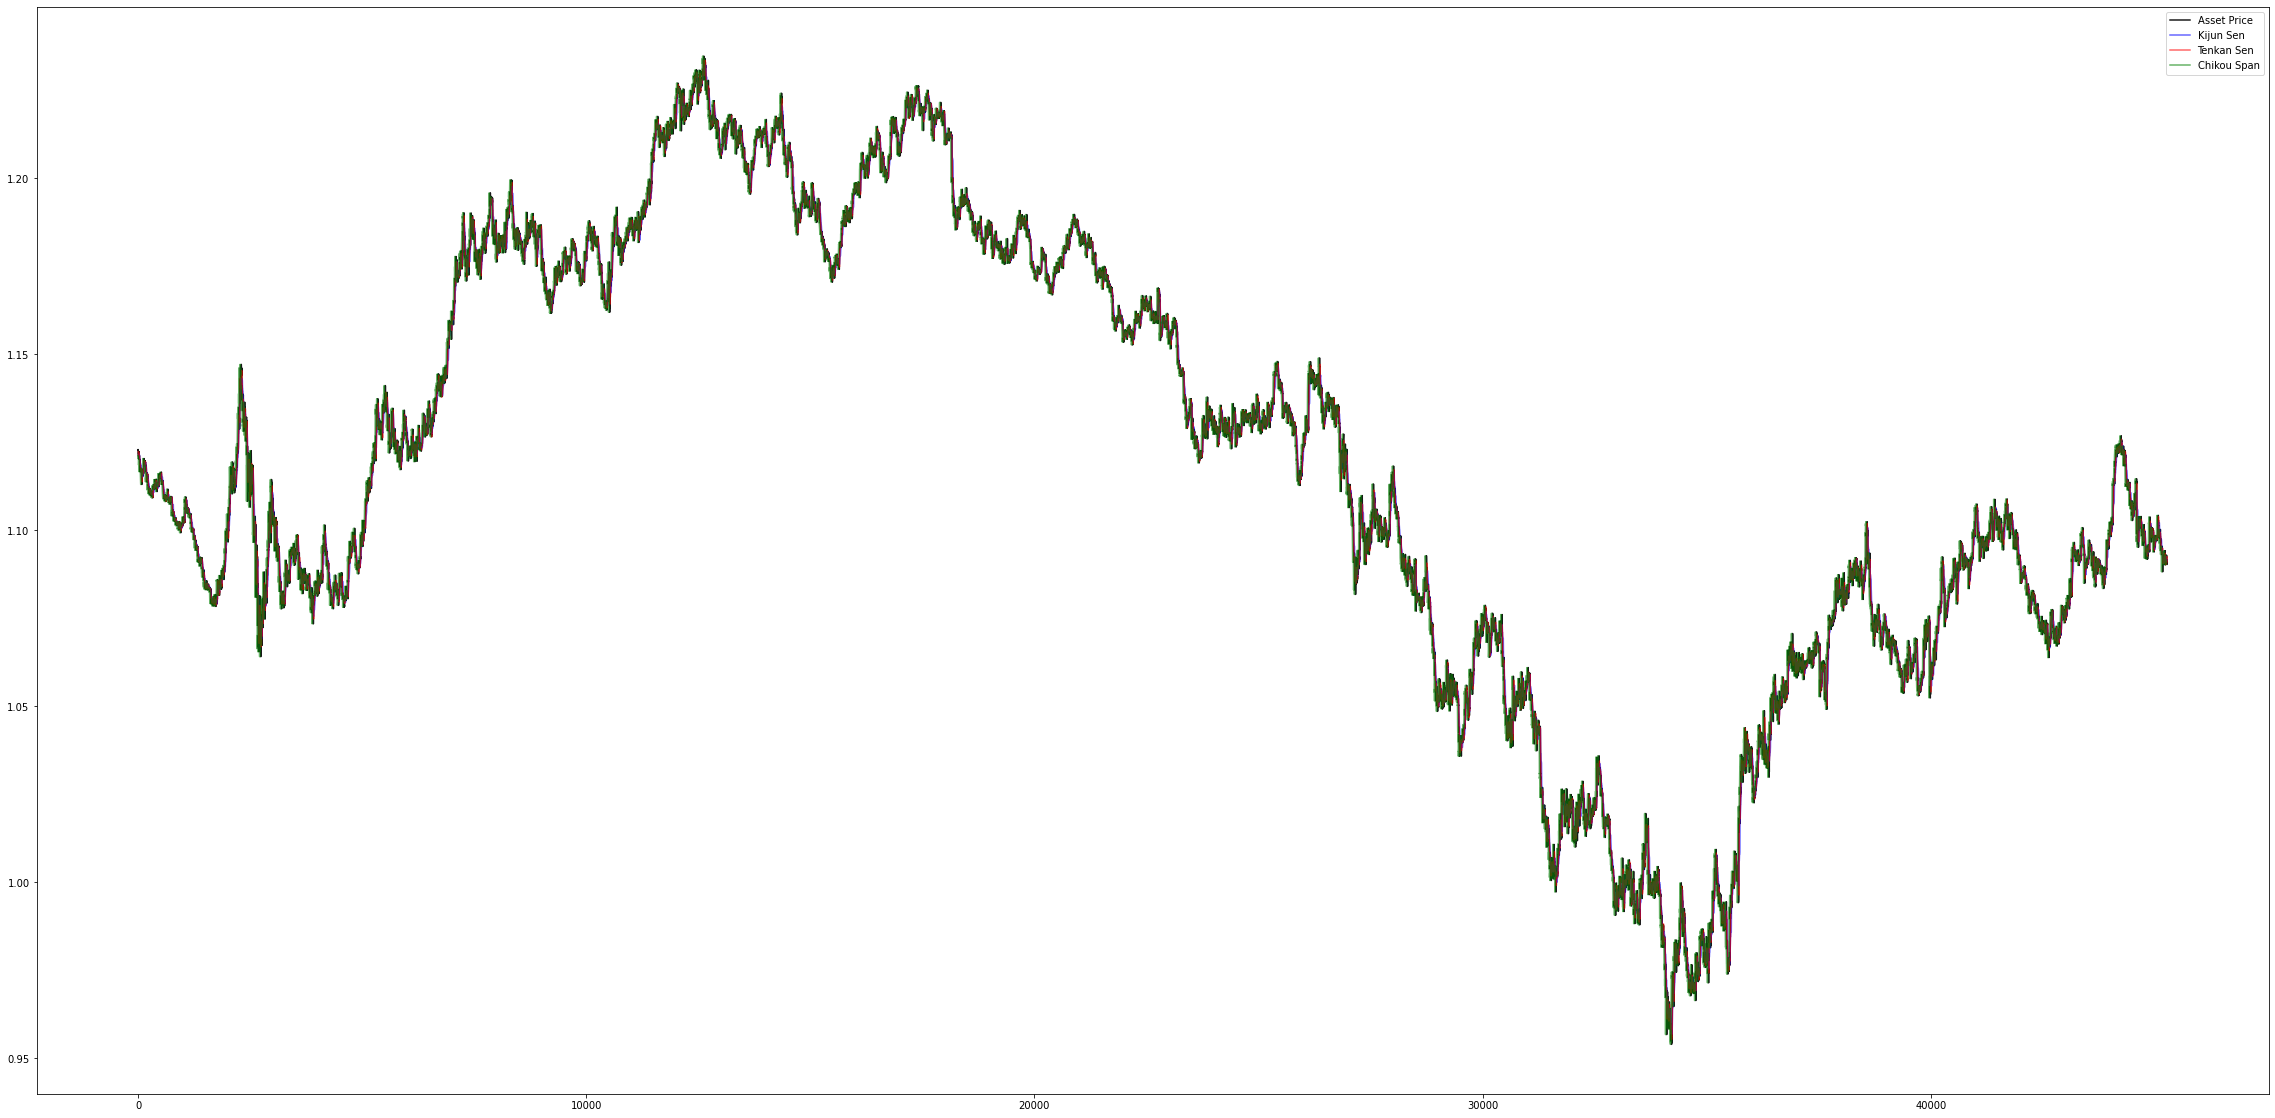

In [243]:





## Increasing the figure size
plt.figure(figsize = (40, 20))

## Plotting the Asset Price.
plt.plot(df['close'], label='Asset Price', c='black', alpha=0.9)
plt.plot(df['kijun_sen'], label='Kijun Sen', c='blue', alpha=0.6)
plt.plot(df['tenkan_sen'], label='Tenkan Sen', c='red', alpha=0.6)
plt.plot(df['chikou_span'], label='Chikou Span', c='green', alpha=0.6)

# Showing the plot
plt.legend()
plt.show()






## Strategy - 1

- A Long (Buy) Signal is generated whenever the Tenkan-sen crosses over the Kijun-sen. At the same time, the Chikou-span must be above the market price.

- A Short (Sell) Signal is generated whenever the Tenken-sen crosses below the Kijun-sen. At the same time, the Chikou-span must be below the market price.


In [244]:



buys = []
sells = []
buyIndices = []
sellIndices = []
openPosition = None


for i in range(len(df)):
    if (i > 0) and (openPosition is None) and (df.iloc[i]['tenkan_sen'] > df.iloc[i]['kijun_sen']) and (df.iloc[i - 1]['tenkan_sen'] < df.iloc[i - 1]['kijun_sen']) and (df.iloc[i]['chikou_span'] > df.iloc[i]['close']):
        openPosition = 'long'
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
    elif (i > 0) and (openPosition) and (df.iloc[i]['tenkan_sen'] < df.iloc[i]['kijun_sen']) and (df.iloc[i - 1]['tenkan_sen'] > df.iloc[i - 1]['kijun_sen']) and (df.iloc[i]['chikou_span'] < df.iloc[i]['close']):
        openPosition = None
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])




In [245]:


print(buyIndices)
print(sellIndices)
print(buys)
print(sells)



[120, 315, 439, 1046, 1371, 1637, 1756, 2171, 2298, 2507, 2753, 2848, 3066, 3265, 3661, 4003, 4146, 4403, 4484, 5042, 5460, 5632, 6050, 6068, 6327, 6790, 7168, 7747, 7965, 8222, 8616, 8906, 9229, 9467, 9650, 9808, 9897, 10153, 10227, 10472, 10614, 10802, 11082, 11774, 12347, 12512, 12914, 13000, 13270, 13275, 13363, 13674, 13845, 13935, 14094, 14190, 14298, 14501, 14763, 14948, 15348, 15631, 15916, 16212, 16472, 16596, 16732, 16978, 17558, 17811, 17862, 18086, 18271, 18464, 18906, 19096, 19186, 19194, 19348, 19462, 20044, 20131, 20390, 20705, 21045, 21339, 21547, 21818, 22005, 22207, 22371, 22632, 22689, 22744, 22836, 23078, 23418, 23442, 23690, 23811, 24117, 24225, 24520, 24601, 24848, 24946, 25092, 25265, 25573, 25670, 25954, 26263, 26477, 26587, 26730, 27252, 27403, 27489, 27699, 27926, 28337, 28455, 28559, 28688, 29020, 29121, 29260, 29508, 29698, 29787, 29923, 30178, 30679, 30744, 30798, 30867, 30934, 31143, 31224, 31648, 32132, 32333, 32431, 32963, 33106, 33166, 33343, 33573, 338

In [246]:





# P & L and other details

totalPL = 0
winTrades = 0
loseTrades = 0
maximumWin = None
maximumLose = None

for i in range(len(sells)):
    netResult = sells[i] - buys[i]

    if netResult < 0:
        loseTrades += 1
    else:
        winTrades += 1

    if not maximumWin:
        maximumWin = netResult
    elif netResult > maximumWin:
        maximumWin = netResult

    if not maximumLose:
        maximumLose = netResult
    elif netResult < maximumLose:
        maximumLose = netResult

    totalPL = totalPL + netResult
    # print(f'Net Trade Result = {netResult}')

print(f'Total P & L = {totalPL}')
print(f'Win Trades = {winTrades}')
print(f'Lose Trades = {loseTrades}')
print(f'Maximum Win = {maximumWin}')
print(f'Maximum Lose = {maximumLose}')







Total P & L = 1.1938399999999993
Win Trades = 163
Lose Trades = 33
Maximum Win = 0.036030000000000006
Maximum Lose = -0.007600000000000051
